#### Week 16 Homework
##### Angela Spencer - January 19, 2022

In [2]:
#dependencies
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours

from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline

from sklearn.metrics import classification_report, roc_curve, roc_auc_score

import matplotlib.pyplot as plt

from sklearn.svm import SVC

#### 1.	Perform combined over and undersampling on the diabetes dataset (use SMOTEENN). Explain how combined sampling works.

Combined resampling uses both oversampling of the minority class and undersampling of the majority class. The method used here is SMOTE-ENN which uses SMOTE (Synthetic Minority Oversampling Technique) to generate new observations in the minority class using a K Nearest Neighbors (KNN) technique to syntesize new observations near existing observations and ENN (Edited Nearest Neighbors) to remove observations from both the majority and minority class using a KNN strategy that removes observations that do not match their neighbors. The result of SMOTEENN resampling is a dataset with a more balanced ratio of classes.

In [3]:
diabetes = pd.read_csv('../Datasets/diabetes.csv')
diabetes

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [4]:
# seperate target variable and features
X = diabetes.drop('Outcome', axis=1)
y = diabetes['Outcome']

#count number of observations in each class for target variable before resampling
y.value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [5]:
resample = SMOTEENN(smote=SMOTE(), 
                    enn=EditedNearestNeighbours(sampling_strategy='all'), 
                    random_state=66)
X_re, y_re = resample.fit_resample(X,y)
y_re.value_counts()

1    287
0    224
Name: Outcome, dtype: int64

#### 2a.	Perform logistic regression with the new data from question 1. 

In [6]:
#split data into training and validation sets using resampled data
X_train, X_test, y_train, y_test = train_test_split(X_re, y_re, test_size=0.3, random_state=66)


In [7]:
#define standardizing object
scale = StandardScaler()

#define regression model
model = LogisticRegression()

#define pipeline and fit to data
pipe = Pipeline(steps=[('scale', scale), 
                       ('model', model)]).fit(X_train, y_train)


print(pipe.score(X_test, y_test))
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

0.8766233766233766
              precision    recall  f1-score   support

           0       0.80      0.92      0.85        61
           1       0.94      0.85      0.89        93

    accuracy                           0.88       154
   macro avg       0.87      0.88      0.87       154
weighted avg       0.88      0.88      0.88       154



#### 2b.	Comment on the performance of combined sampling vs the other approaches we have used for the diabetes dataset.

- Week 13 - KNN w/optimal K value and scaling score = 0.75
- Week 14 - Logistic Regression w/ scaling,  score = 0.71, precision 0.75/0.60, recall 0.82/0.50
- Week 15 - Logistic Regression w/ scaling and undersampling, score = 0.75, precision 0.82/0.64, recall 0.80/0.67

The previous three weeks have produced accuracy scores around 70% with KNN vs Logistic Regression vs. Logistic regression with undersampling.  The accuracy score this week with undersampling, oversampling, scaling, and Logistic Regression produced the best accuracy score by far.  Achieving 88% accuracy and very high precision and recall scores as well.

#### 3a.	Create an ROC Curve for the model https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html and calculate the AUC. 

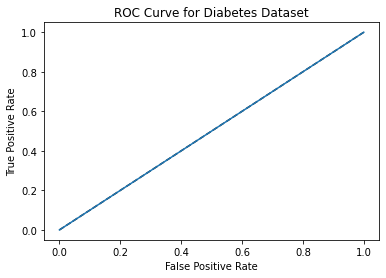

In [8]:
#calculate predicted probabilities
y_pred_prob = model.predict_proba(X_test)[:,1]

#generate ROC values and store in variables
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

#plot ROC curve
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Diabetes Dataset')
plt.show()

In [9]:
#calculate and print the AUC score 
print("AUC score: {}".format(roc_auc_score(y_test, y_pred_prob)))

AUC score: 0.5


#### 3b.	BRIEFLY explain what the ROC Curve shows and what the resulting AUC means. 

The ROC Curve (Reviever Operating Characteristic Curve) is a plot of the true positive rate (recall) against the false positive rate and plots the relationship between the two at different thresholds. Lowering the classification threshold means fewer observations are classified as positive and it reduces the number of true positives and false negatives respectively.  AUC (Area Under ROC Curve) is the two dimensional area beneath the ROC curve and ranges from 0 (0% accuracy) to 1 (100% accuracy).

#### 4.	What is outlier detection? Why is it useful? What methods can you use for outlier detection?

Outliers are data points that are observations that do not fit the data, often seen as points that are far away from the other observations in two-dimensional representations. These outliers reduce the fit of a model and reduce performance metrics. As the number of dimensions in the dataset increase, it can be difficult to visually reresent outliers and mathematically difficult to correct them (through techniques such as standard deviation). For data models that have high dimensionality, there are several techniques for detecting and outliers, including: Isolation Forest (anomaly detection through decision tree modeling), Minimum Covariance Determinate (anomaly detection for Gaussian distiributed features), Local Outlier Factor (anomaly detection through a Nearest Neighbor technique) and One-Class SVM (anomaly detection through support vectors).

#### 5a.	Perform a linear SVM to predict credit approval (last column) using this dataset: 
        https://archive.ics.uci.edu/ml/datasets/Statlog+%28Australian+Credit+Approval%29 . 
#### Make sure you look at the accompanying document that describes the data in the dat file. You will need to either convert this data to another file type or import the dat file to python. You can use this code, but otherwise you follow standard practices we have already used many times: 
        from sklearn.svm import SVC
        classifier = SVC(kernel='linear')

In [10]:
data = np.loadtxt('../Datasets/australian.dat')
credit = pd.DataFrame(data, columns = ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15'])
credit

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15
0,1.0,22.08,11.460,2.0,4.0,4.0,1.585,0.0,0.0,0.0,1.0,2.0,100.0,1213.0,0.0
1,0.0,22.67,7.000,2.0,8.0,4.0,0.165,0.0,0.0,0.0,0.0,2.0,160.0,1.0,0.0
2,0.0,29.58,1.750,1.0,4.0,4.0,1.250,0.0,0.0,0.0,1.0,2.0,280.0,1.0,0.0
3,0.0,21.67,11.500,1.0,5.0,3.0,0.000,1.0,1.0,11.0,1.0,2.0,0.0,1.0,1.0
4,1.0,20.17,8.170,2.0,6.0,4.0,1.960,1.0,1.0,14.0,0.0,2.0,60.0,159.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,1.0,31.57,10.500,2.0,14.0,4.0,6.500,1.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0
686,1.0,20.67,0.415,2.0,8.0,4.0,0.125,0.0,0.0,0.0,0.0,2.0,0.0,45.0,0.0
687,0.0,18.83,9.540,2.0,6.0,4.0,0.085,1.0,0.0,0.0,0.0,2.0,100.0,1.0,1.0
688,0.0,27.42,14.500,2.0,14.0,8.0,3.085,1.0,1.0,1.0,0.0,2.0,120.0,12.0,1.0


In [11]:
X = credit.drop('A15', axis=1)
y = credit['A15']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=66)

svm = SVC()
svm.fit(X_train, y_train)
svm.score(X_test, y_test)

0.6183574879227053

In [12]:
scale = StandardScaler()
svm = SVC()

pipe = Pipeline(steps=[('scale', scale), ('svm', svm)]).fit(X_train, y_train)
pipe.score(X_test, y_test)

0.855072463768116

#### 5b.	How did the SVM model perform? 

The SVM model had an accuracy of 0.86 with scaling and 0.62 without scaling.

#### 6.	What kinds of jobs in data are you most interested in? Do some research on what is out there. Write about your thoughts in under 400 words. 

I am most interested in Python based jobs and machine learning. Without much advanced math experience, I believe I will be able to find something as a Junior Data Scientist working with data cleaning and preparation for Machine Learning. Hopefully I can find a company that will help me learn and grow into a more advanced role in this field.